In [13]:
import json
import random
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K
import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import time
import math

from matplotlib.colors import LinearSegmentedColormap
import colorsys
import numpy as np
    
from data_retrieval_relocation_3ksol_reloc import INSTANCEProvider
from kbh_yard_b2b_relocation import KBH_Env                               #This is the environment of the shunting yard
from dqn_kbh_colfax_relocation_test_agent import DQNAgent

In [14]:
# this function returns random colors for visualisation of learning.
def rand_cmap(nlabels, type='soft', first_color_black=True, last_color_black=False):
    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)
    return random_colormap


In [15]:
#1526820866 is the 220k expensive relocation model.

In [16]:
for model_nr in ['1526820866']:
    #which model to load.
    test_case = model_nr
    
    #LOAD THE INSTANCE PROVIDER
    ig = INSTANCEProvider()
    instances = ig.instances
    # Create environment KBH
    yrd = KBH_Env()

    # Create the DQNAgent with the CNN approximation of the Q-function and its experience replay and training functions.
    # load the trained model.
    agent = DQNAgent(yrd, True, test_case)

    # set epsilon to 0 to act just greedy
    agent.epsilon = 0

    #new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False, verbose=True)
    
    visualization = False
    
    n = len(instances)
    
    # result vectors
    original_lengths = []
    terminated_at_step = []
    success = []
    relocations = []
    print_count = 0
    
    
    # train types different tracks? 
    type_step_track = []
    
       
    for instance in instances:
        nr_relocations = 0
        if print_count % 100 == 0:
            print(print_count)
        print_count = print_count + 1
        #Initialize problem
        event_list = ig.get_instance(instance)
        
        steps, t, total_t, score= len(event_list), 0, 0, 0

        state = yrd.reset(event_list)  # Get first observation based on the first train arrival.
        history = np.reshape(state, (
            1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape state into tensor, which we call history.

        done, busy_relocating = False, False
        
        if visualization:
            #visualize learning
            new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False)

        if visualization == True:
            plt.imshow(np.float32(history[0][0]), cmap=new_cmap, interpolation='nearest')
            plt.show()

        while not done:
            action = agent.get_action(history)  # RL choose action based on observation

            if visualization == True:
                print(agent.model.predict(history))
                print(action+1)
#             # RL take action and get next observation and reward
#             # note the +1 at action

            # save for arrival activities the parking location
            event_list_temp = event_list.reset_index(drop=True).copy()
            if event_list_temp.event_type[0]=='arrival':
                train_type = event_list_temp.composition[0]
                type_step_track.append({'type': train_type, 'action': action+1, 'step':t, 'instance_id': instance})


            # based on that action now let environment go to new state
            event = event_list.iloc[0]
            # check if after this we are done... 
            done_ = True if len(event_list) == 1 else False  # then there is no next event
#             if done_:
#                 print("Reached the end of a problem!")
            if busy_relocating:
                # here we do not drop an event from the event list.
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                next_state, reward, done = yrd.reloc_destination_step(event, event_list, action+1, coming_arrivals, coming_departures, done_)
                nr_relocations += 1
                busy_relocating = False
            else: 
                # These operations below are expensive: maybe just use indexing.
                event_list.drop(event_list.index[:1], inplace=True)
                coming_arrivals = event_list.loc[event_list['event_type'] == 'arrival'].reset_index(drop=True)
                coming_departures = event_list.loc[event_list['event_type'] == 'departure'].reset_index(drop=True)

                # do step
                next_state, reward, done = yrd.step(action+1, coming_arrivals, coming_departures, event, event_list, done_)

                busy_relocating = True if reward == -0.5 else False

            history_ = np.float32(np.reshape(next_state, (1, yrd.shape[0], yrd.shape[1], yrd.shape[2])))
            
            score += reward  # log direct reward of action

            if visualization == True: 
                #show action
                plt.imshow(np.float32(history_[0][0]), cmap=new_cmap, interpolation='nearest')
                plt.show()
                time.sleep(0.05)
                if reward == -1:
                    time.sleep(1)
                print(reward)

            if done:  # based on what the environment returns.
                #print('ended at step' , t+1)
                #print('original length', steps)
                original_lengths.append(steps)
                terminated_at_step.append(t+1)
                relocations.append(nr_relocations)
                if int(np.unique(history_)[0]) == 1: #then we are in win state
                    success.append(1)
                else: 
                    success.append(0)
                break;

            history = history_  # next state now becomes the current state.
            t += 1  # next step in this episode
    
    #save data needed for Entropy calculations.
    df_type_step_track = pd.DataFrame.from_records(type_step_track)
    df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
    df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
    filename = 'data_'+model_nr+'_relocation_arrival_actions.csv'
    df_type_step_track.to_csv(filename)
    
#     analysis_runs = pd.DataFrame(
#     {'instance_id': instances,
#      'original_length': original_lengths,
#      'terminated_at_step': terminated_at_step
#     })
 
#     analysis_runs['solved'] = analysis_runs.apply(lambda row: 1 if row.original_length == row.terminated_at_step else 0, axis =1 )
#     analysis_runs['tried'] = analysis_runs.apply(lambda row: 1 if row.terminated_at_step != -1 else 0, axis =1)
#     analysis_runs['percentage'] = analysis_runs.apply(lambda row: row.solved/755, axis=1)
    
#     analysis_runs.to_csv('best_model_solved_instances.csv')
#     print('Model: ', model_nr)
#     summary = analysis_runs.groupby('original_length', as_index=False)[['solved', 'tried', 'percentage']].sum()
#     print(summary)
    
#     #print hist
#     %matplotlib inline  
#     #%%
#     # analyse the parking actions per step and train type
#     df_type_step_track = pd.DataFrame.from_records(type_step_track)
#     bins = [1,2,3,4,5,6,7,8,9,10]
#     plt.hist(df_type_step_track.action, bins, align='left')
    
#     #prepare for save
#     df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
#     df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
#     filename = 'data_'+model_nr+'_paper.csv'
#     df_type_step_track.to_csv(filename)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 33, 32)         16928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 33, 64)         8256      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               540928    
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 2313      
Total params: 568,425
Trainable params: 568,425
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv

In [17]:
analysis_runs = pd.DataFrame(
{'instance_id': instances,
 'original_length': original_lengths,
 'terminated_at_step': terminated_at_step,
 'success': success,
 'nr_relocations': relocations
})


In [18]:
analysis_runs.sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step
2442,6442,0,46,0,8
3008,7008,0,46,0,8
2638,6638,0,46,0,10
2877,6877,0,46,0,10
2937,6937,0,46,0,10
2594,6594,0,46,0,11
2593,6593,0,46,0,11
1970,5970,0,43,0,11
2459,6459,0,46,0,11
2973,6973,0,46,0,11


In [19]:
print(analysis_runs.loc[analysis_runs.success == 0].instance_id.to_string(index=False))

4000
4022
4066
4123
4188
4220
4254
4263
4336
4345
4374
4453
4473
4484
4505
4529
4644
4699
4769
4802
4808
4860
4892
4895
4900
4905
4906
4919
4992
5008
5019
5021
5038
5085
5108
5149
5153
5190
5196
5201
5204
5210
5211
5224
5246
5256
5279
5299
5310
5337
5346
5359
5363
5386
5394
5402
5407
5421
5433
5455
5469
5473
5477
5483
5510
5524
5537
5560
5583
5584
5594
5618
5619
5624
5653
5654
5699
5705
5733
5762
5788
5794
5796
5829
5831
5838
5857
5915
5927
5970
5982
5988
6002
6029
6035
6046
6078
6093
6128
6146
6203
6209
6215
6240
6254
6260
6265
6266
6272
6277
6288
6295
6296
6298
6301
6302
6303
6305
6311
6322
6335
6338
6351
6357
6361
6363
6369
6391
6404
6406
6417
6419
6421
6422
6431
6433
6437
6438
6442
6447
6449
6458
6459
6465
6475
6477
6485
6491
6509
6514
6516
6527
6532
6538
6543
6544
6549
6550
6560
6562
6565
6575
6582
6585
6588
6589
6593
6594
6606
6607
6613
6616
6617
6626
6627
6628
6637
6638
6646
6651
6657
6663
6673
6676
6677
6682
6689
6690
6700
6715
6734
6745
6757
6767
6770
6773
6777
6791
6796
6806


In [20]:
analysis_runs.loc[analysis_runs.success == 1].copy().groupby('nr_relocations')[['instance_id']].count()

,instance_id
nr_relocations,
0,1917
1,760
2,97
3,11
4,1


In [21]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].sum()
print(summary)


   original_length  success
0               37      737
1               41      709
2               43      713
3               46      627


In [22]:
summary = analysis_runs.groupby('original_length', as_index=False)[['success']].mean()
print(summary)


   original_length   success
0               37  0.976159
1               41  0.939073
2               43  0.944371
3               46  0.830464


4


(array([  2.02200000e+03,   8.64000000e+02,   1.17000000e+02,
          1.60000000e+01,   1.00000000e+00]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

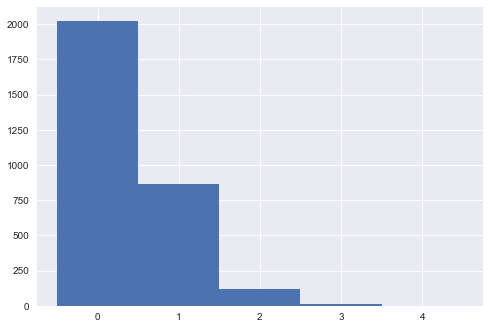

In [23]:
max_reloc = max(analysis_runs.nr_relocations)
print(max_reloc)
plt.hist(analysis_runs.nr_relocations, bins=range(0,max_reloc+2), align='left')


  instance_size  nr_relocations
0            14        0.312076
1            15        0.370945
2            16        0.308555
3            17        0.443381


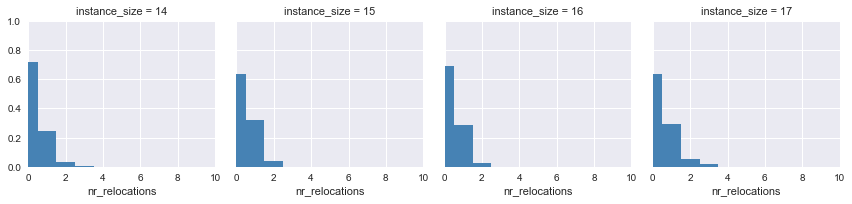

In [123]:
import seaborn as sns
sns.set(style="darkgrid")
analysis_runs['instance_size'] = analysis_runs.apply(lambda row: str(row.original_length).replace('37', '14').replace('41', '15').replace('43', '16').replace('46','17'), axis=1)

g = sns.FacetGrid(analysis_runs, col="instance_size", margin_titles=True)
bins = range(0,max_reloc+2)
g.set(ylim=(0, 1), xlim=(0,10))
g.map(plt.hist, "nr_relocations", color="steelblue", bins=bins, lw=0, align='left', normed=1)

print(analysis_runs.loc[analysis_runs.success == 1].groupby('instance_size', as_index=False)[['nr_relocations']].mean())

sns.plt.savefig('220k_reloc_distr.eps')

# analysis of mistakes



In [57]:
analysis_runs.loc[analysis_runs.success == 0].sort_values('terminated_at_step')

,instance_id,nr_relocations,original_length,success,terminated_at_step,instance_size
3008,7008,0,46,0,8,17
2442,6442,0,46,0,8,17
2937,6937,0,46,0,10,17
2877,6877,0,46,0,10,17
2638,6638,0,46,0,10,17
2363,6363,0,46,0,11,17
2361,6361,0,46,0,11,17
2809,6809,0,46,0,11,17
2465,6465,0,46,0,11,17
2831,6831,0,46,0,11,17


(0, 50)


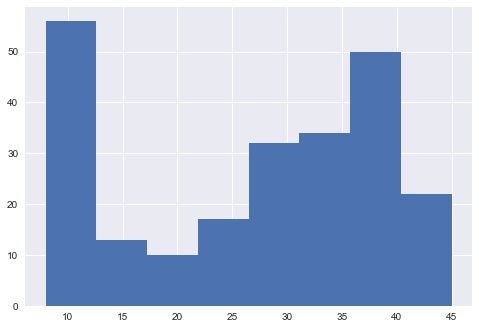

In [93]:
import matplotlib.pyplot as plt2
fig = plt2.hist(analysis_runs.loc[analysis_runs.success == 0].terminated_at_step, bins=8)
print(plt.ylim)
plt.ylim = (0,55)
plt.show()



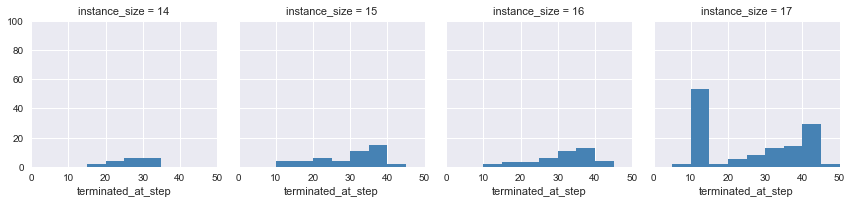

In [111]:
#plt.hist(analysis_runs.loc[analysis_runs.success == 0].terminated_at_step, bins=8)

len(analysis_runs.loc[analysis_runs.success == 0])

analysis_runs['instance_size'] = analysis_runs.apply(lambda row: str(row.original_length).replace('37', '14').replace('41', '15').replace('43', '16').replace('46','17'), axis=1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

bins = [0,5,10,15,20,25,30,35,40,45,50]

g = sns.FacetGrid(analysis_runs.loc[analysis_runs.success == 0], col="instance_size", margin_titles=True)
g.set(ylim=(0, 100), xlim=(0,50))
g.map(plt.hist, "terminated_at_step", color="steelblue", bins = bins, lw=0)

sns.plt.savefig('220k_failures.eps')

In [33]:
print(analysis_runs.original_length.value_counts())

43    755
41    755
37    755
46    755
Name: original_length, dtype: int64
